In [47]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize


# WSL not working with jypyter notebook

import ase
from ase import Atoms
from ase.units import eV, Ang, GPa

import Morse

import sys
sys.path.append(r'files')
# set facecolor to white
plt.rcParams['figure.facecolor'] = 'white'

In [48]:
# This code was written by myself as I thought I was meant to write it myself
# However I am still unsure as code has been provided as an attached calculator for ASE

def interaction_potential(r, r0, alpha):
    dr = r - r0
    return np.exp(- 2 * alpha * dr) - 2 * np.exp( - alpha * dr)

def morse_potential(positions, r0, alpha, D ):
    # loop for each pair of atoms once
    for i in range(len(positions)):
        for j in range(i+1, len(positions)): # i never equals j
            r = np.linalg.norm(positions[i] - positions[j])
            if r < r0:
                return D * interaction_potential(r, r0, alpha)
    

Text(0.5, 1.0, 'Morse Potential Energy vs Distance for 2 Cu atoms')

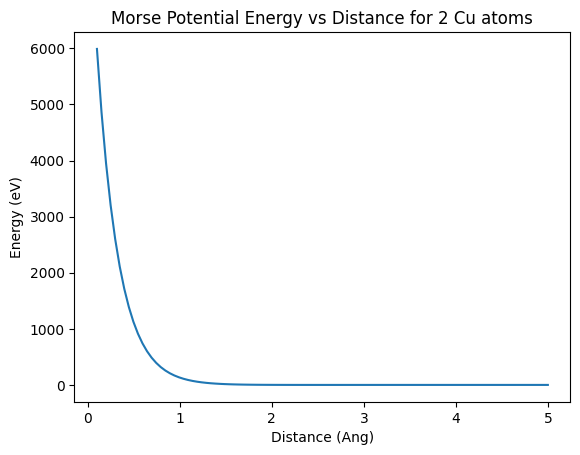

In [49]:

energies = []
distances = Ang*np.linspace(0.1, 5, 100)

for d in distances:

    a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., d)])
    calc = Morse.MorsePotential()
    a.set_calculator(calc)
    energies.append(a.get_potential_energy())

plt.plot(distances, energies)
plt.xlabel('Distance (Ang)')
plt.ylabel('Energy (eV)')
plt.title('Morse Potential Energy vs Distance for 2 Cu atoms')


Text(0, 0.5, 'Force (eV/Ang)')

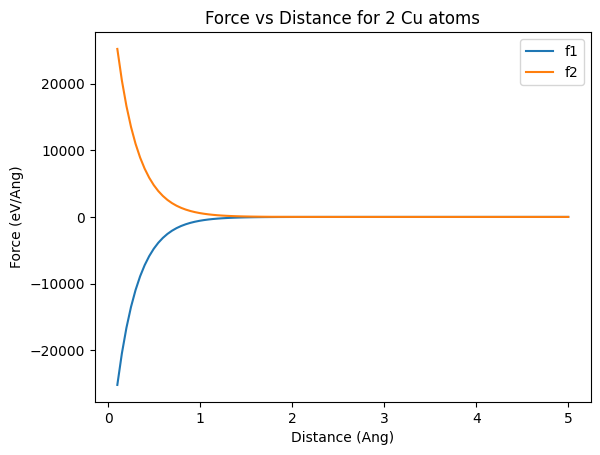

In [50]:
f1 = []
f2 = []
distances = Ang*np.linspace(0.1, 5, 100)

for d in distances:

    a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., d)])
    calc = Morse.MorsePotential()
    a.set_calculator(calc)
    f1.append(a.get_forces()[0,2])
    f2.append(a.get_forces()[1,2])

plt.plot(distances, f1, label='f1')
plt.plot(distances, f2, label='f2')
plt.legend()
plt.title('Force vs Distance for 2 Cu atoms')
plt.xlabel('Distance (Ang)')
plt.ylabel('Force (eV/Ang)')


In [51]:
# Write a unit test that verifies that the forces returned by the get_forces() function 
# is really the negative gradient of the energy (as returned by the get_potential_energy() function) 
# with respect to the atomic positions. Do this by comparing the forces returned by get_forces() to those 
# obtained by numerical finite differences of energies between two sets of atomic positions, displaced by small amount.

import unittest

class TestMorsePotential(unittest.TestCase):
    def test_get_forces(self):
        eta = 1e-10
        a1 = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., 1.5)])
        a2 = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., 1.5 + eta * Ang)])
        calc = Morse.MorsePotential()
        a1.set_calculator(calc)
        a2.set_calculator(calc)
        f1 = a1.get_forces()[0,2]
        e1 = a1.get_potential_energy()
        e2 = a2.get_potential_energy()
        f2 = (e2 - e1) / (eta * Ang)
        self.assertAlmostEqual(f1, f2, places=3)

# run the unit test
unittest.main(argv=[''], verbosity=2, exit=False)

test_get_forces (__main__.TestMorsePotential) ... c:\Users\louis\AppData\Local\Programs\Python\Python310\lib\site-packages\ase\utils\__init__.py:62: DeprecationWarning: Please use atoms.calc = calc
  warnings.warn(warning)
ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


For small $\epsilon$ unit test fails (When $\epsilon < 1e-10$) as is not accurate within 3 places

For large $\epsilon$ unit test also fails (When $\epsilon > 1e-6$) as is again not accurate to within 3 places

As $\epsilon$ tends to zero so does $\nabla E$ and $f$

Task 3

c:\Users\louis\AppData\Local\Programs\Python\Python310\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


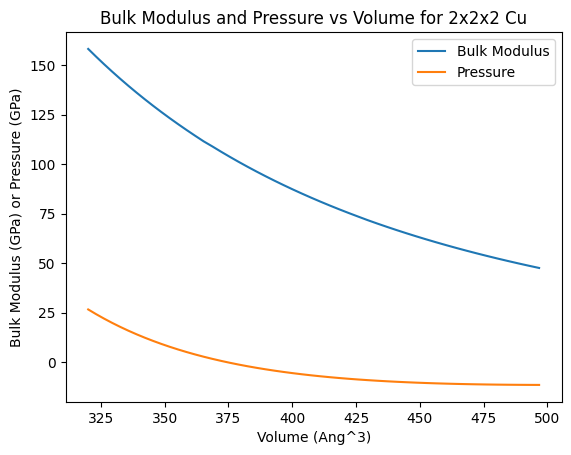

In [52]:
from ase.build import bulk#
from ase.units import eV, Ang, GPa, kJ

strains = np.linspace(-0.05, 0.1, 50)

vols = []
Ks = []
Ps = []
energies = []

for s in strains:

    cu = bulk("Cu", "fcc", a=3.6, cubic=True)

    calc = Morse.MorsePotential()
    cu.set_calculator(calc)
    cu222 = cu.copy()        # creating a copy of an Atoms object
    cu222.set_calculator(calc) # copying DOES NOT bring the attached calculator, so we need to set it again
    cu222 *= (2,2,2)         # replicating the unit cell is accomplished by the multiplying operator

    # pre strain
    V1 = cu222.get_volume()
    P1 = - 1/3 * np.trace(cu222.get_stress(voigt=False))

    # applying strain
    cell = cu222.get_cell()
    cell *= (1 + s)
    cu222.set_cell(cell, scale_atoms=True) # To apply strain, the atomic positions need to be scaled together with the unit cell 
    cu222.get_cell()

    # post strain
    V2 = cu222.get_volume()
    P2 = - 1/3 * np.trace(cu222.get_stress(voigt=False))
    K = - V2 * (P2 - P1) / (V2 - V1)
    e = cu222.get_potential_energy()

    # converting to eV/Ang^3 to GPa
    K = K / kJ * 1e24
    # converting to eV/Ang^3 to GPa
    P = P2 / kJ * 1e24

    vols.append(V2)
    Ks.append(K)
    Ps.append(P)
    energies.append(e)

    #print(P)

plt.plot(vols, Ks, label='Bulk Modulus') # plotting the bulk modulus as a function of the volume
plt.plot(vols, Ps, label='Pressure') # plotting pressure  as a function of the volume
plt.xlabel('Volume (Ang^3)')
plt.ylabel('Bulk Modulus (GPa) or Pressure (GPa)')
plt.title('Bulk Modulus and Pressure vs Volume for 2x2x2 Cu')
plt.legend()


Correct range of Bulk Moduli

Minimum energy:  -37.436062982003804 eV
Volume at minimum energy:  375.53785866609996 Ang^3
Bulk modulus at minimum energy:  103.70228122910169 GPa


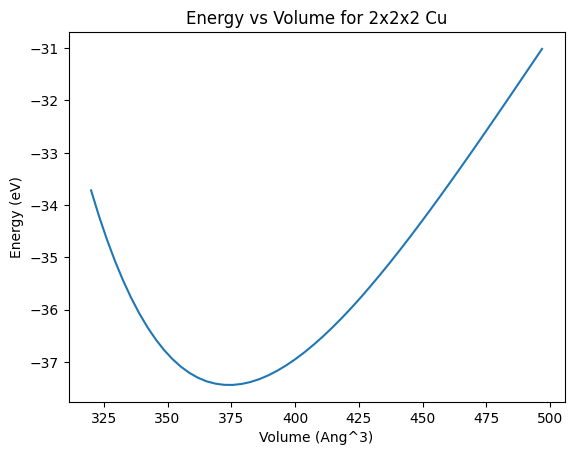

In [53]:
plt.plot(vols, energies)
plt.xlabel('Volume (Ang^3)')
plt.ylabel('Energy (eV)')
plt.title('Energy vs Volume for 2x2x2 Cu')
# print the minimum energy and the corresponding volume
print('Minimum energy: ', min(energies), 'eV')
print('Volume at minimum energy: ', vols[energies.index(min(energies))], 'Ang^3')
print('Bulk modulus at minimum energy: ', Ks[energies.index(min(energies))], 'GPa')
equ_strain = strains[energies.index(min(energies))] / vols[0]

Task 4 part 1

Write a program to compute the shear modulus.

In [54]:
L = 3.6

cu = bulk("Cu", "fcc", a=L, cubic=True)
calc = Morse.MorsePotential()
cu.set_calculator(calc)
cu222 = cu.copy()        # creating a copy of an Atoms object
cu222.set_calculator(calc) # copying DOES NOT bring the attached calculator, so we need to set it again
cu222 *= (2,2,2)         # replicating the unit cell is accomplished by the multiplying operator

# apply shear strain
cell = cu222.get_cell()
cell[0,1] = 0.01 * L
cu222.set_cell(cell, scale_atoms=True)

S = cu222.get_stress(voigt=False)

Observe which components of the stress matrix is nonzero, and think about which one you need to work out the shear modulus.

In [55]:
G = S[0,1] / 0.01
# converting to eV/Ang^3 to GPa
G = G / kJ * 1e24
print(G)

43.18521625908336


Close! Actual shear modulus for copper is 44 GPa

Part 2 Write a program to determine the Poisson ratio

The Poisson ratio depends very sensitively on the starting volume, so make sure you use the unit cell size that corresponds to the lowest energy, accurate to at least 4 decimal places.

In [66]:
volume_at_minimum_energy = vols[energies.index(min(energies))]
L = (volume_at_minimum_energy / 8)**(1/3)

strain = 0.01

cu = bulk("Cu", "fcc", a=L, cubic=True)
calc = Morse.MorsePotential()
cu.set_calculator(calc)
#cu222 = cu.copy()        # creating a copy of an Atoms object
#cu222.set_calculator(calc) # copying DOES NOT bring the attached calculator, so we need to set it again
#cu222 *= (2,2,2)         # replicating the unit cell is accomplished by the multiplying operator

# apply shear strain
cell = cu.get_cell()
cell *= (1 + strain, 1, 1) # 1% strain in x direction
cu.set_cell(cell, scale_atoms=True)

# compute stresses
S = cu.get_stress(voigt=False)

# get poissons ratio by - transaxial strain / axial strain
nu = abs(S[1,1] / S[0,0])

print(nu)

0.6831760808014232


c:\Users\louis\AppData\Local\Programs\Python\Python310\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


In [67]:
cu2=bulk("Cu", "fcc", a=3.6, cubic=True)
cu2.set_calculator(Morse.MorsePotential())
#calculate equilibirium cell
cell_original=cu2.get_cell(cu2)
cell_equ=cell_original*equ_strain
#set shear matrix
shear_arr=np.array([[1,0,0],[0.005,1,0],[0,0,1]])
cell_shear=np.dot(shear_arr,cell_equ)
#apply shear
cu2.set_cell(cell_shear)
stress=cu2.get_stress(voigt=False)
G=stress[0,1]*200/GPa
print("the shear modulus of copper is:"+str(G)+" GPa")
cu3=bulk("Cu", "fcc", a=3.6, cubic=True)
cu3.set_calculator(Morse.MorsePotential())
#calculate equilibirium cell
cell_original=cu2.get_cell(cu2)
cell_equ=cell_original*equ_strain
#initiate main loop
v_array=np.linspace(0.2,0.6,50)
v_array.tolist()
l_py=[]
for i in v_array:
    strain_matrix=np.array([[1.01,0,0],[0,(1-0.01*i),0],[0,0,(1-0.01*i)]])
    cell1=np.dot(strain_matrix,cell_equ)
    cu3.set_cell(cell1,scale_atoms=True)
    stress=cu3.get_stress(voigt=False)
    l_py.append(abs(stress[1,1]))
min_index=l_py.index(min(l_py))
p=v_array[min_index]
print(p)

KeyboardInterrupt: 

Dislocations move diagonally until they reach a pin or obstruction or wall boundary at which they can deflect causing another dislocation which forms a small neck in the bottom plate

The notch grows wider and deeper as a large amount of plastic deformation occurs in the center, this creates a rough break in the material